<a href="https://colab.research.google.com/github/Legacy560/MTLSA25-Sales-Forecasting-Project/blob/main/Cleaning%20and%20ARIMA/MLTSA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cd /content/drive/Shareddrives/MLTSA25-Sales-Forecasting/Project

/content/drive/Shareddrives/MLTSA25-Sales-Forecasting/Project


In [ ]:
cal = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')
salesVal = pd.read_csv('sales_train_validation.csv')

In [ ]:
display(cal.head())
display(salesVal.head())
display(prices.head())

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

# **Reshape sales data into long format.**

This allows for us to merge the sales dataset with the calendar dataset. These datasets are large, however; and any operations will cause the Python session to crash. Thus, before we can do anything else, we need to deal with the storage and memory that these datasets take up.

In [ ]:
#This code came from: https://www.kaggle.com/competitions/m5-forecasting-accuracy/data. I take no credit for it.

#Downcast in order to save memory
def downcast(df):

  '''
  Changes column types in the dataframe to reduce memory usage.
  Input:
    df (pandas dataframe): dataframe to be downcast.
  Output:
    df (pandas dataframe): dataframe with reduced memory usage.
  '''
  cols = df.dtypes.index.tolist()
  types = df.dtypes.values.tolist()
  for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
  return df

salesVal = downcast(salesVal)
prices = downcast(prices)
cal = downcast(cal)

In [ ]:
salesValLong = salesVal.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                         var_name="d", value_name="units_sold").dropna()
#This gives us a column "d" containing each sales day. This is the same as the "d" column from calendar

In [ ]:
del salesVal

In [ ]:
#Check for missing values
display(salesValLong.isnull().sum())
display(cal.isnull().sum())
display(prices.isnull().sum())

id            0
item_id       0
dept_id       0
cat_id        0
store_id      0
state_id      0
d             0
units_sold    0
dtype: int64

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

# Merging Datasets

In [ ]:
#Merge with Calendar dataset
salesValLong1 = salesValLong.merge(cal, on="d", how="left")
display(salesValLong1.head())
del salesValLong
del cal

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  units_sold       date  wm_yr_wk  ... wday  month  year  \
0       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   
1       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   
2       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   
3       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   
4       CA  d_1           0 2011-01-29     11101  ...    1      1  2011   

   event_name_1 event_type_1 event_name_2 event_type_2 snap_CA  snap_TX  \
0           NaN          NaN          NaN          NaN       0        0   
1           NaN          NaN          NaN          NaN       0        0   
2           NaN          NaN          NaN          NaN       0        0   
3           NaN          NaN          NaN          NaN       0        0   
4           NaN          NaN          NaN          NaN       0        0   

   snap_WI  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 21 columns]

In [ ]:
#Merge with prices dataset
salesFull = salesValLong1.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")
display(salesFull.head())
del salesValLong1
del prices

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  units_sold       date  wm_yr_wk  ... month  year  \
0       CA  d_1           0 2011-01-29     11101  ...     1  2011   
1       CA  d_1           0 2011-01-29     11101  ...     1  2011   
2       CA  d_1           0 2011-01-29     11101  ...     1  2011   
3       CA  d_1           0 2011-01-29     11101  ...     1  2011   
4       CA  d_1           0 2011-01-29     11101  ...     1  2011   

   event_name_1  event_type_1 event_name_2 event_type_2 snap_CA snap_TX  \
0           NaN           NaN          NaN          NaN       0       0   
1           NaN           NaN          NaN          NaN       0       0   
2           NaN           NaN          NaN          NaN       0       0   
3           NaN           NaN          NaN          NaN       0       0   
4           NaN           NaN          NaN          NaN       0       0   

   snap_WI  sell_price  
0        0         NaN  
1        0         NaN  
2        0         NaN  
3        0         NaN  
4        0         NaN  

[5 rows x 22 columns]

In [ ]:
salesFull.shape

(58327370, 22)

In [ ]:
display(salesFull.columns)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'units_sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [ ]:
salesFull.describe()

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


units_sold                           date      wm_yr_wk  \
count  5.832737e+07                       58327370  5.832737e+07   
mean   1.126322e+00  2013-09-11 00:00:00.000000768  1.133919e+04   
min    0.000000e+00            2011-01-29 00:00:00  1.110100e+04   
25%    0.000000e+00            2012-05-21 00:00:00  1.121700e+04   
50%    0.000000e+00            2013-09-11 00:00:00  1.133300e+04   
75%    1.000000e+00            2015-01-02 00:00:00  1.144800e+04   
max    7.630000e+02            2016-04-24 00:00:00  1.161300e+04   
std    3.873108e+00                            NaN  1.503742e+02   

               wday         month          year       snap_CA       snap_TX  \
count  5.832737e+07  5.832737e+07  5.832737e+07  5.832737e+07  5.832737e+07   
mean   3.997386e+00  6.357554e+00  2.013209e+03  3.293257e-01  3.293257e-01   
min    1.000000e+00  1.000000e+00  2.011000e+03  0.000000e+00  0.000000e+00   
25%    2.000000e+00  3.000000e+00  2.012000e+03  0.000000e+00  0.000000e+00   
50%    4.000000e+00  6.000000e+00  2.013000e+03  0.000000e+00  0.000000e+00   
75%    6.000000e+00  9.000000e+00  2.015000e+03  1.000000e+00  1.000000e+00   
max    7.000000e+00  1.200000e+01  2.016000e+03  1.000000e+00  1.000000e+00   
std    2.000652e+00  3.458773e+00  1.532086e+00  4.699684e-01  4.699684e-01   

            snap_WI    sell_price  
count  5.832737e+07  4.602796e+07  
mean   3.293257e-01           NaN  
min    0.000000e+00  1.000214e-02  
25%    0.000000e+00  2.179688e+00  
50%    0.000000e+00  3.470703e+00  
75%    1.000000e+00  5.839844e+00  
max    1.000000e+00  1.073125e+02  
std    4.699684e-01  0.000000e+00

In [ ]:
#Check for missing values in full dataset
display(salesFull.isnull().sum())

#Add total sale column
salesFull['total_sale'] = salesFull['units_sold'] * salesFull['sell_price']

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
units_sold             0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1    53631910
event_type_1    53631910
event_name_2    58205410
event_type_2    58205410
snap_CA                0
snap_TX                0
snap_WI                0
sell_price      12299413
dtype: int64

In [ ]:
salesFull.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  units_sold       date  wm_yr_wk  ...  year  event_name_1  \
0       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   
1       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   
2       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   
3       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   
4       CA  d_1           0 2011-01-29     11101  ...  2011           NaN   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI  \
0           NaN           NaN          NaN       0       0       0   
1           NaN           NaN          NaN       0       0       0   
2           NaN           NaN          NaN       0       0       0   
3           NaN           NaN          NaN       0       0       0   
4           NaN           NaN          NaN       0       0       0   

   sell_price  total_sale  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN  

[5 rows x 23 columns]

Filtering data on the base of state, Califonia


In [ ]:
salesFull=salesFull[salesFull['state_id'] == 'CA']

In [ ]:
salesFull.shape

(23330948, 23)

In [ ]:
np.random.seed(42)
random_item_ids = np.random.choice(salesFull['item_id'].unique(), size=10, replace=False)
display(random_item_ids)

array(['HOUSEHOLD_2_422', 'FOODS_3_145', 'FOODS_2_135', 'HOBBIES_1_352',
       'FOODS_3_439', 'HOUSEHOLD_2_077', 'FOODS_3_452', 'HOUSEHOLD_1_472',
       'FOODS_2_257', 'HOUSEHOLD_2_349'], dtype=object)

In [ ]:
salesFull = salesFull[salesFull['item_id'].isin(random_item_ids)]

In [ ]:
salesFull.shape

(76520, 23)

# Data Analysis

Ploting of time series graph with good visuals was talking a lot of time and memory so we used Power BI for visualization part.

Power BI report link: https://drive.google.com/file/d/1QHiKeDMdUiLHiZoEa3E7S19d1km1YmEw/view?usp=drive_link



Time series graph for Total UNIT_SOLD by YEARMONTH and ITEM_ID

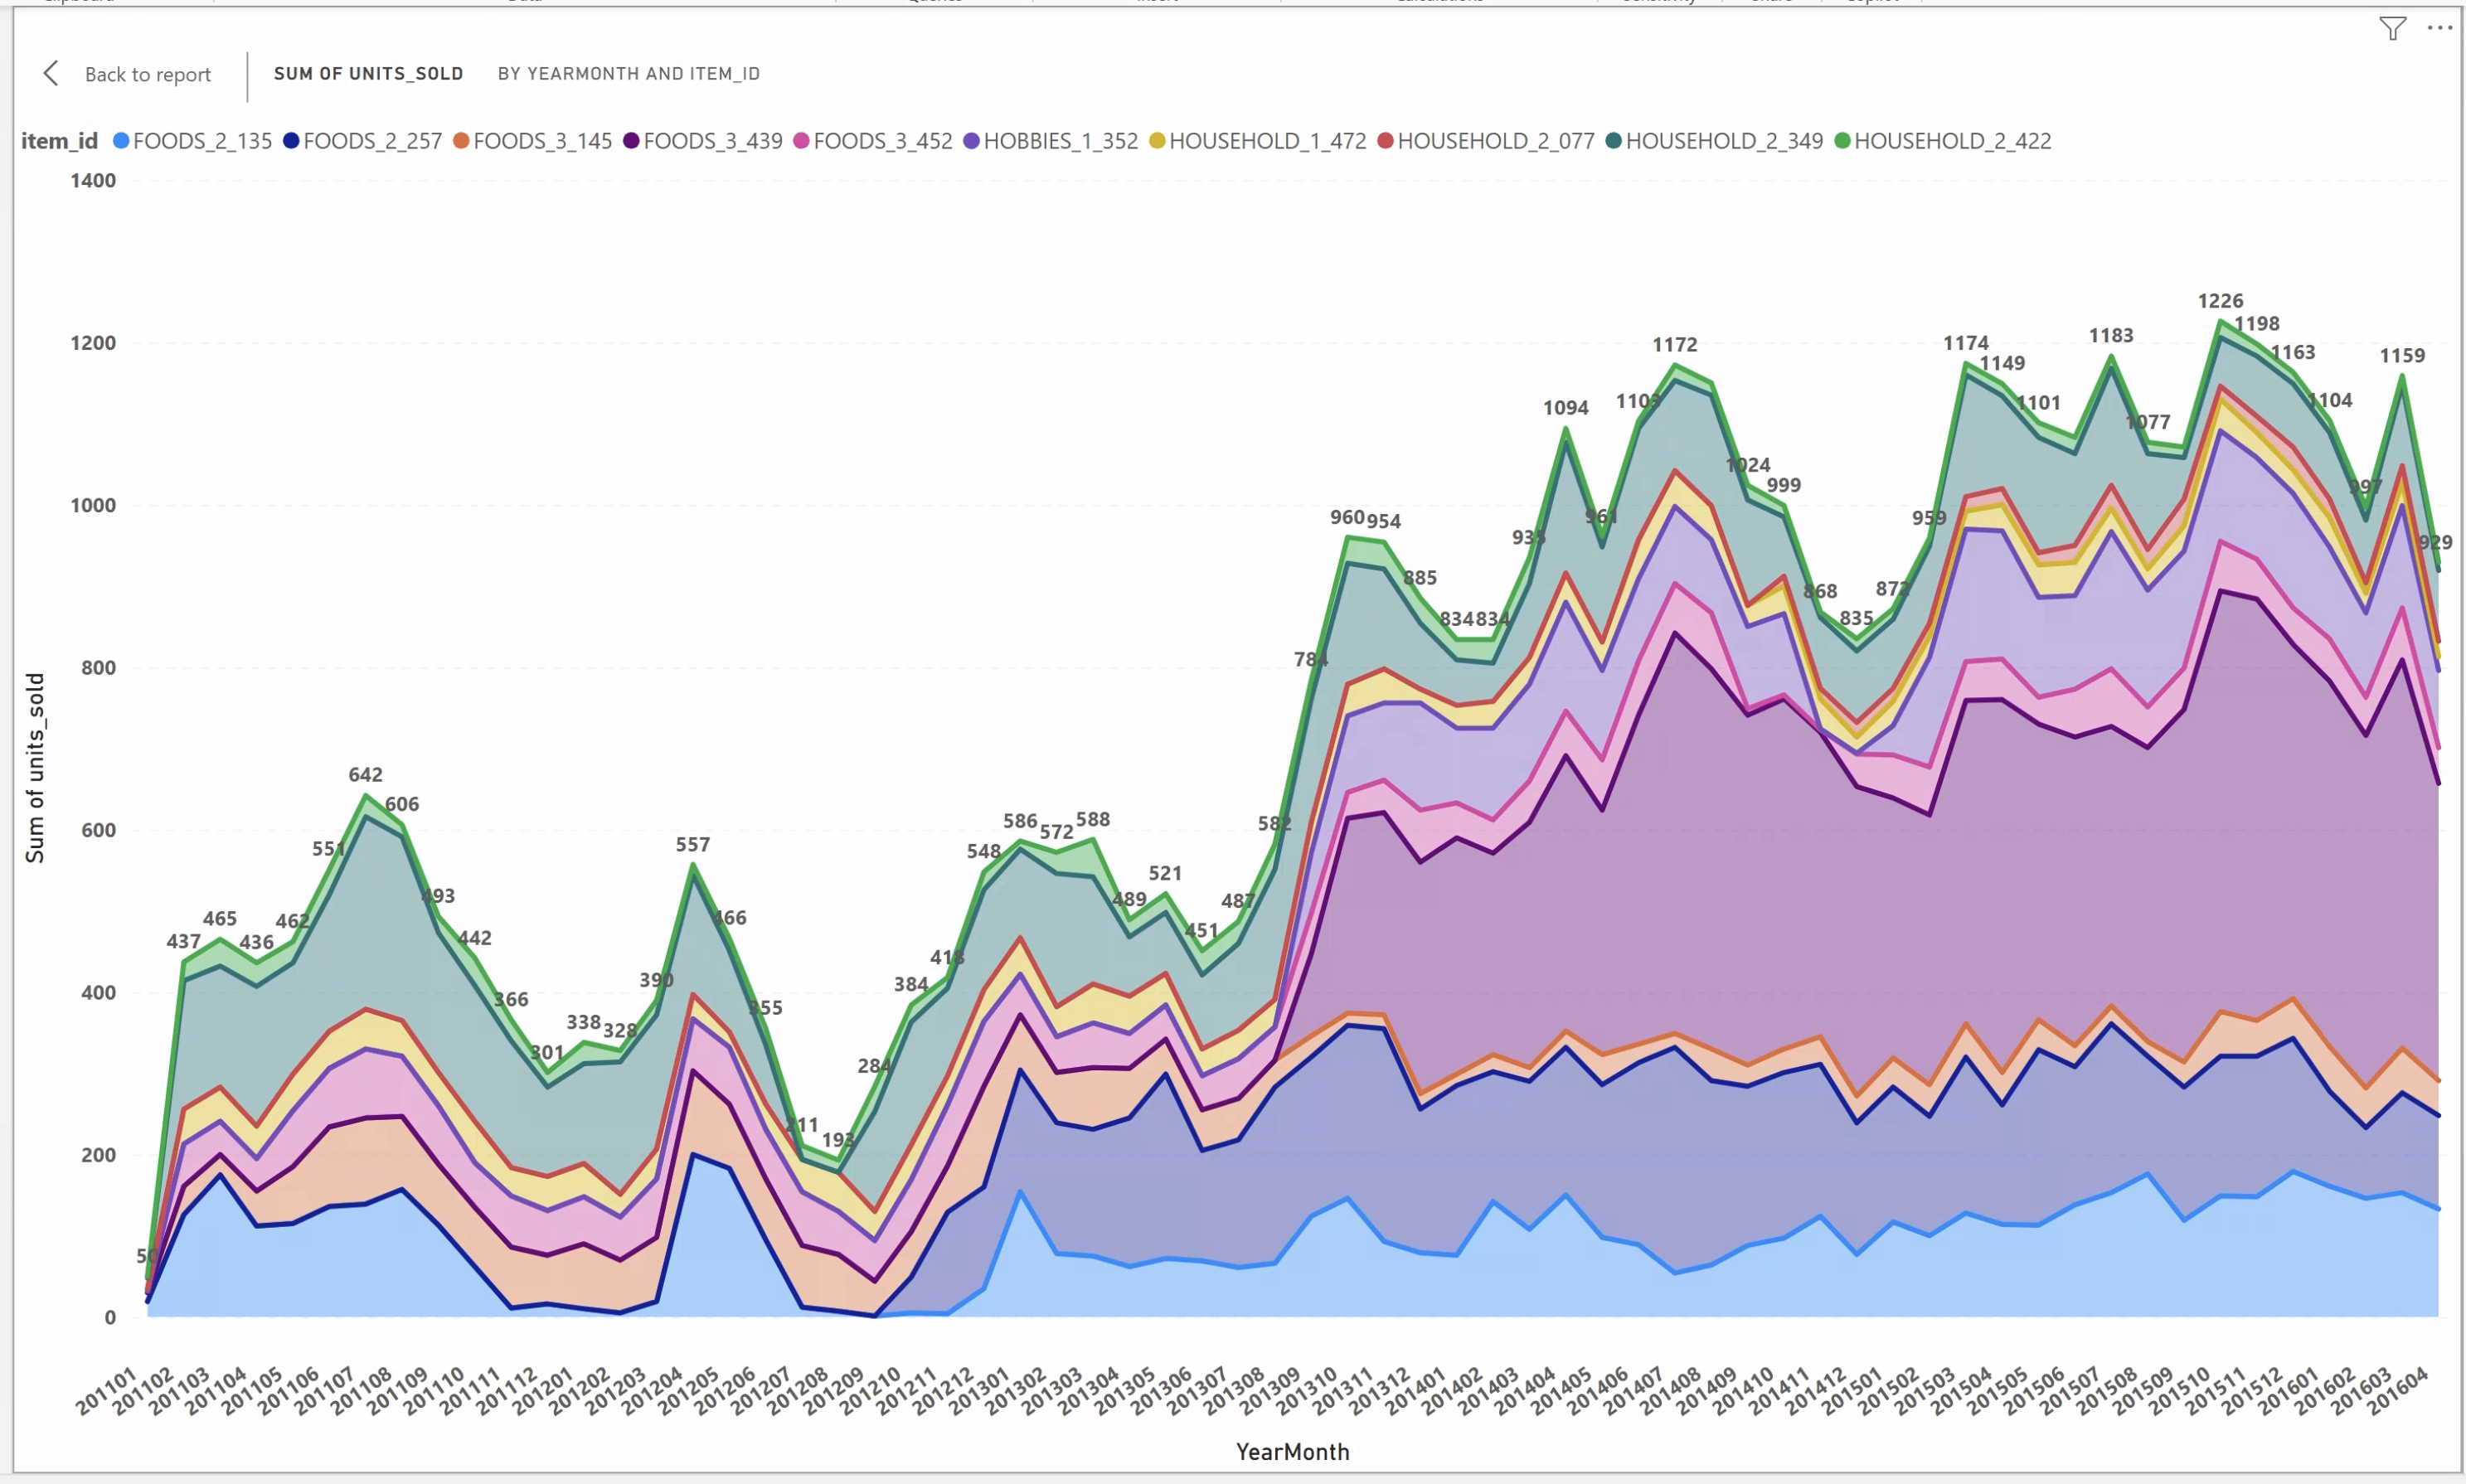

Pie Chart Total UNIT_SOLD by STORE_ID and CAT_ID

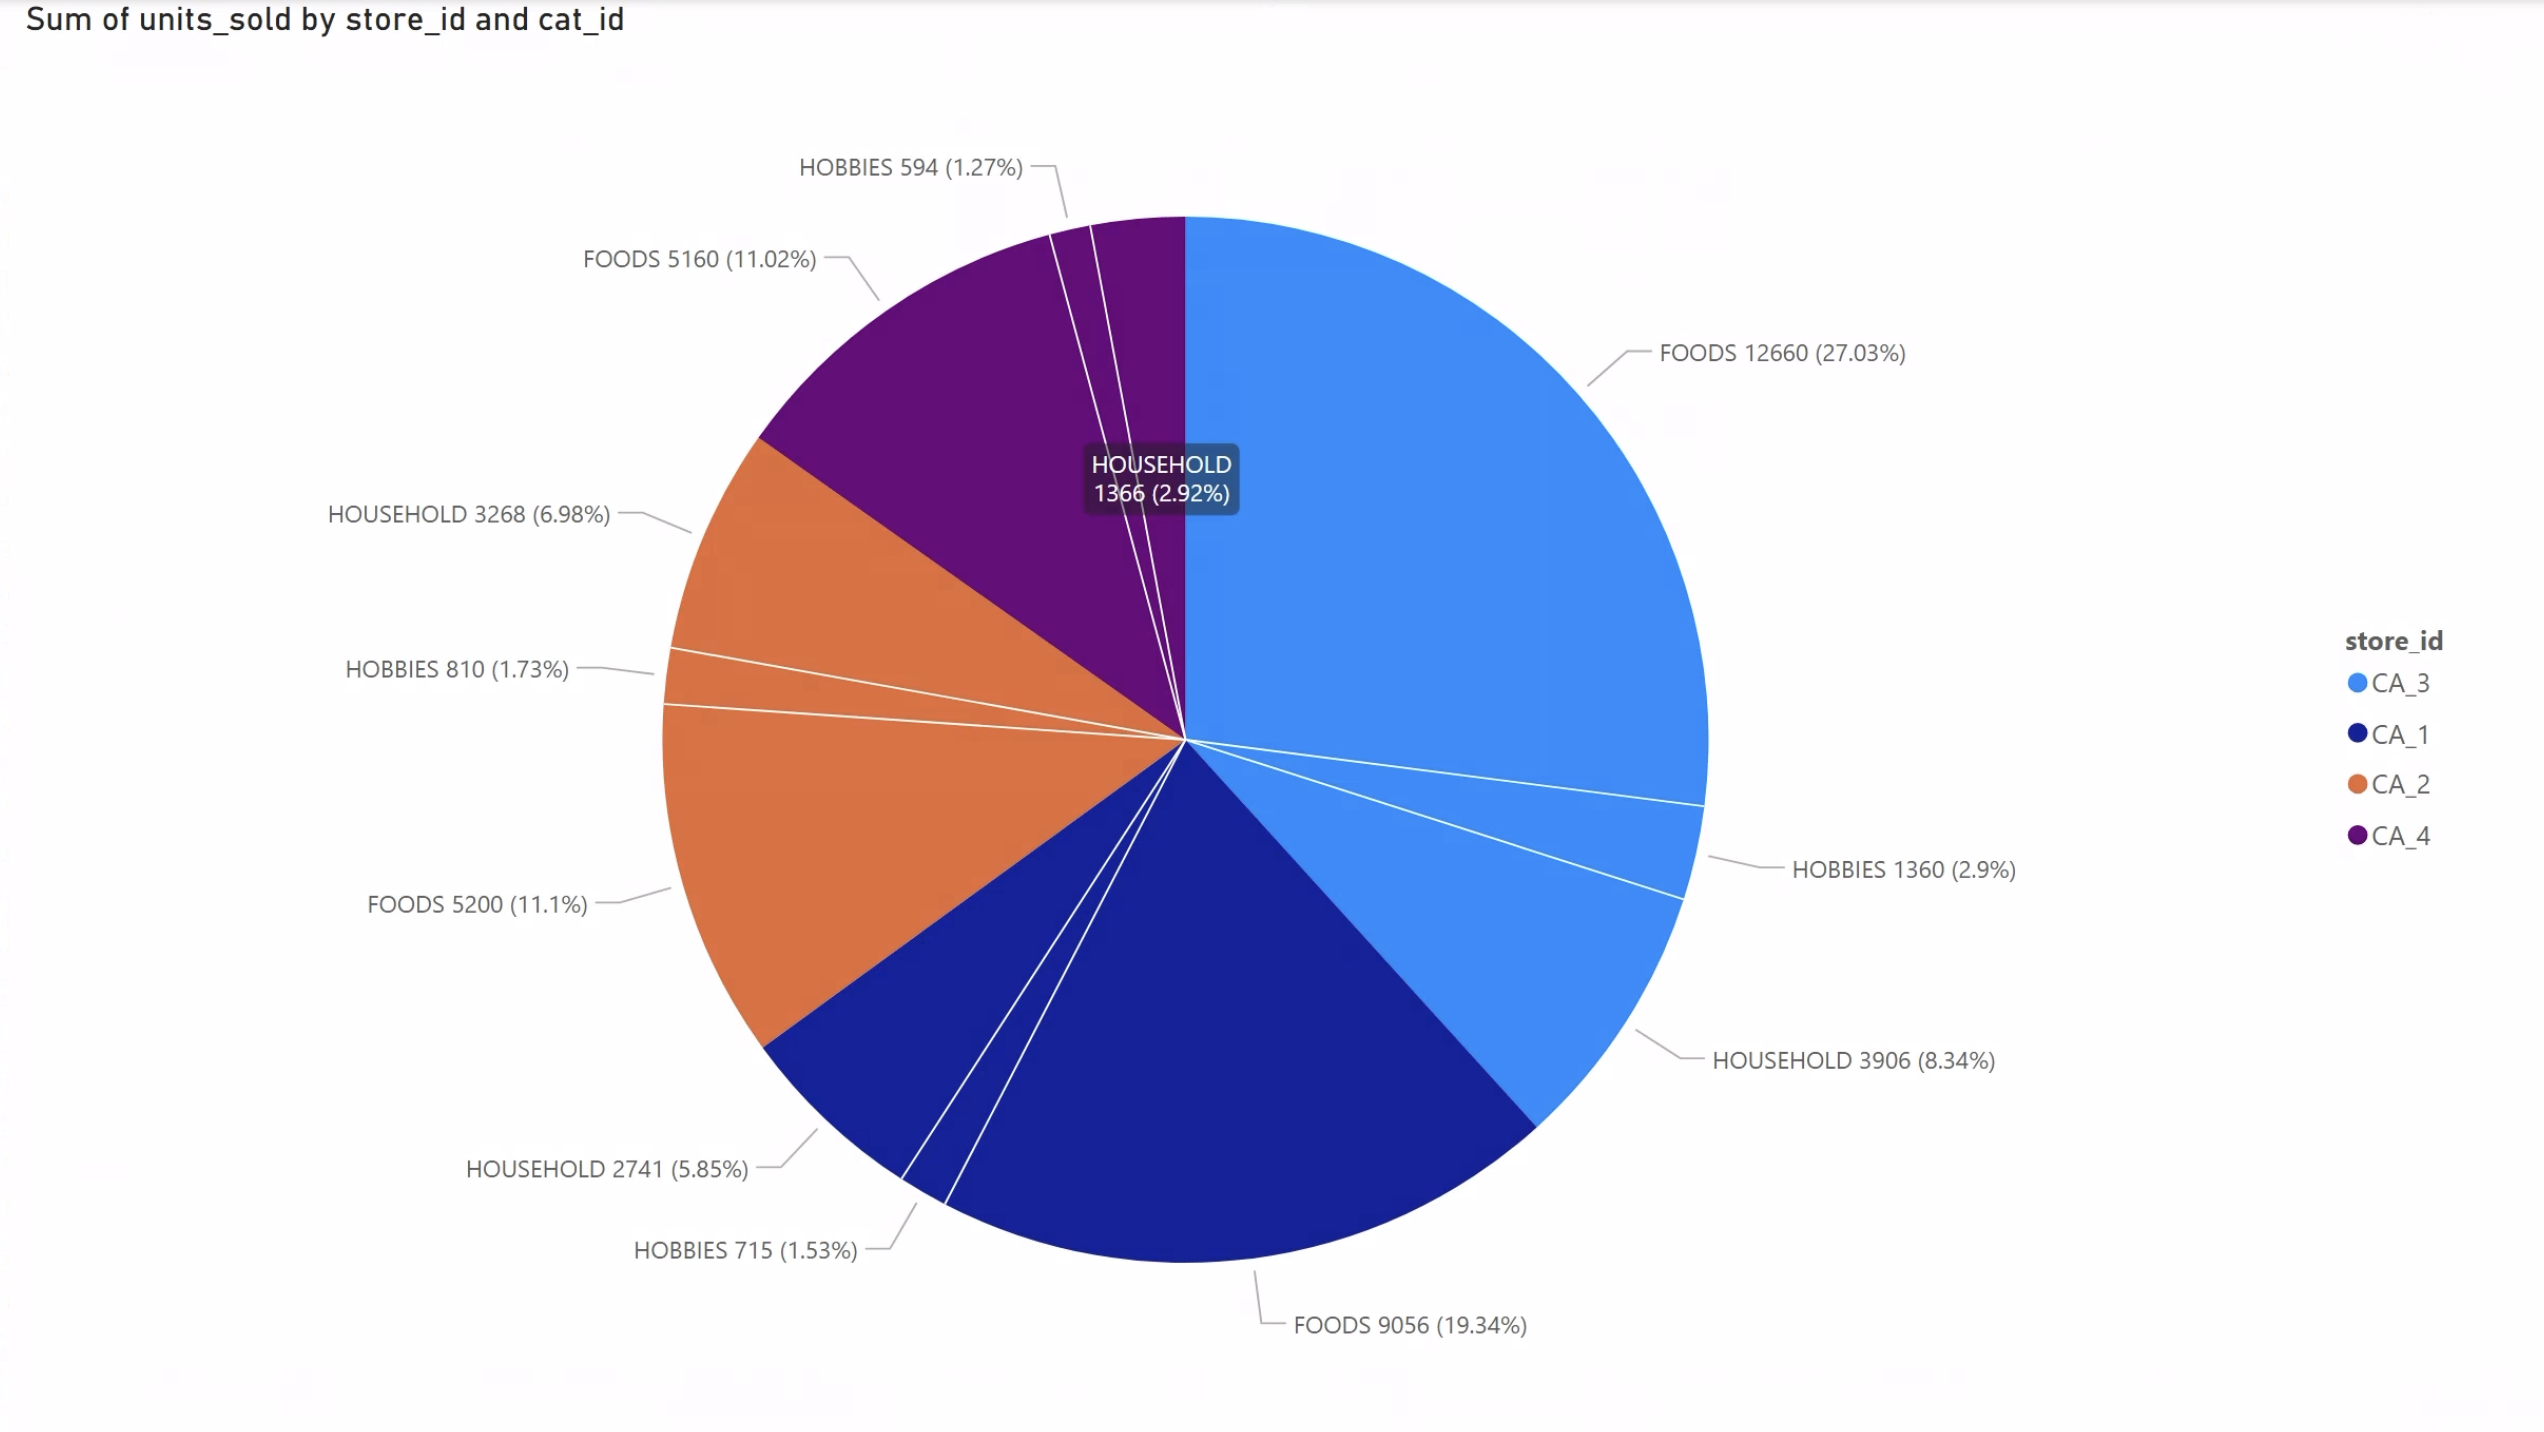

Box and Whiskey Plot for Total SELL_PRICE by ID,Store_ID and CAT_ID

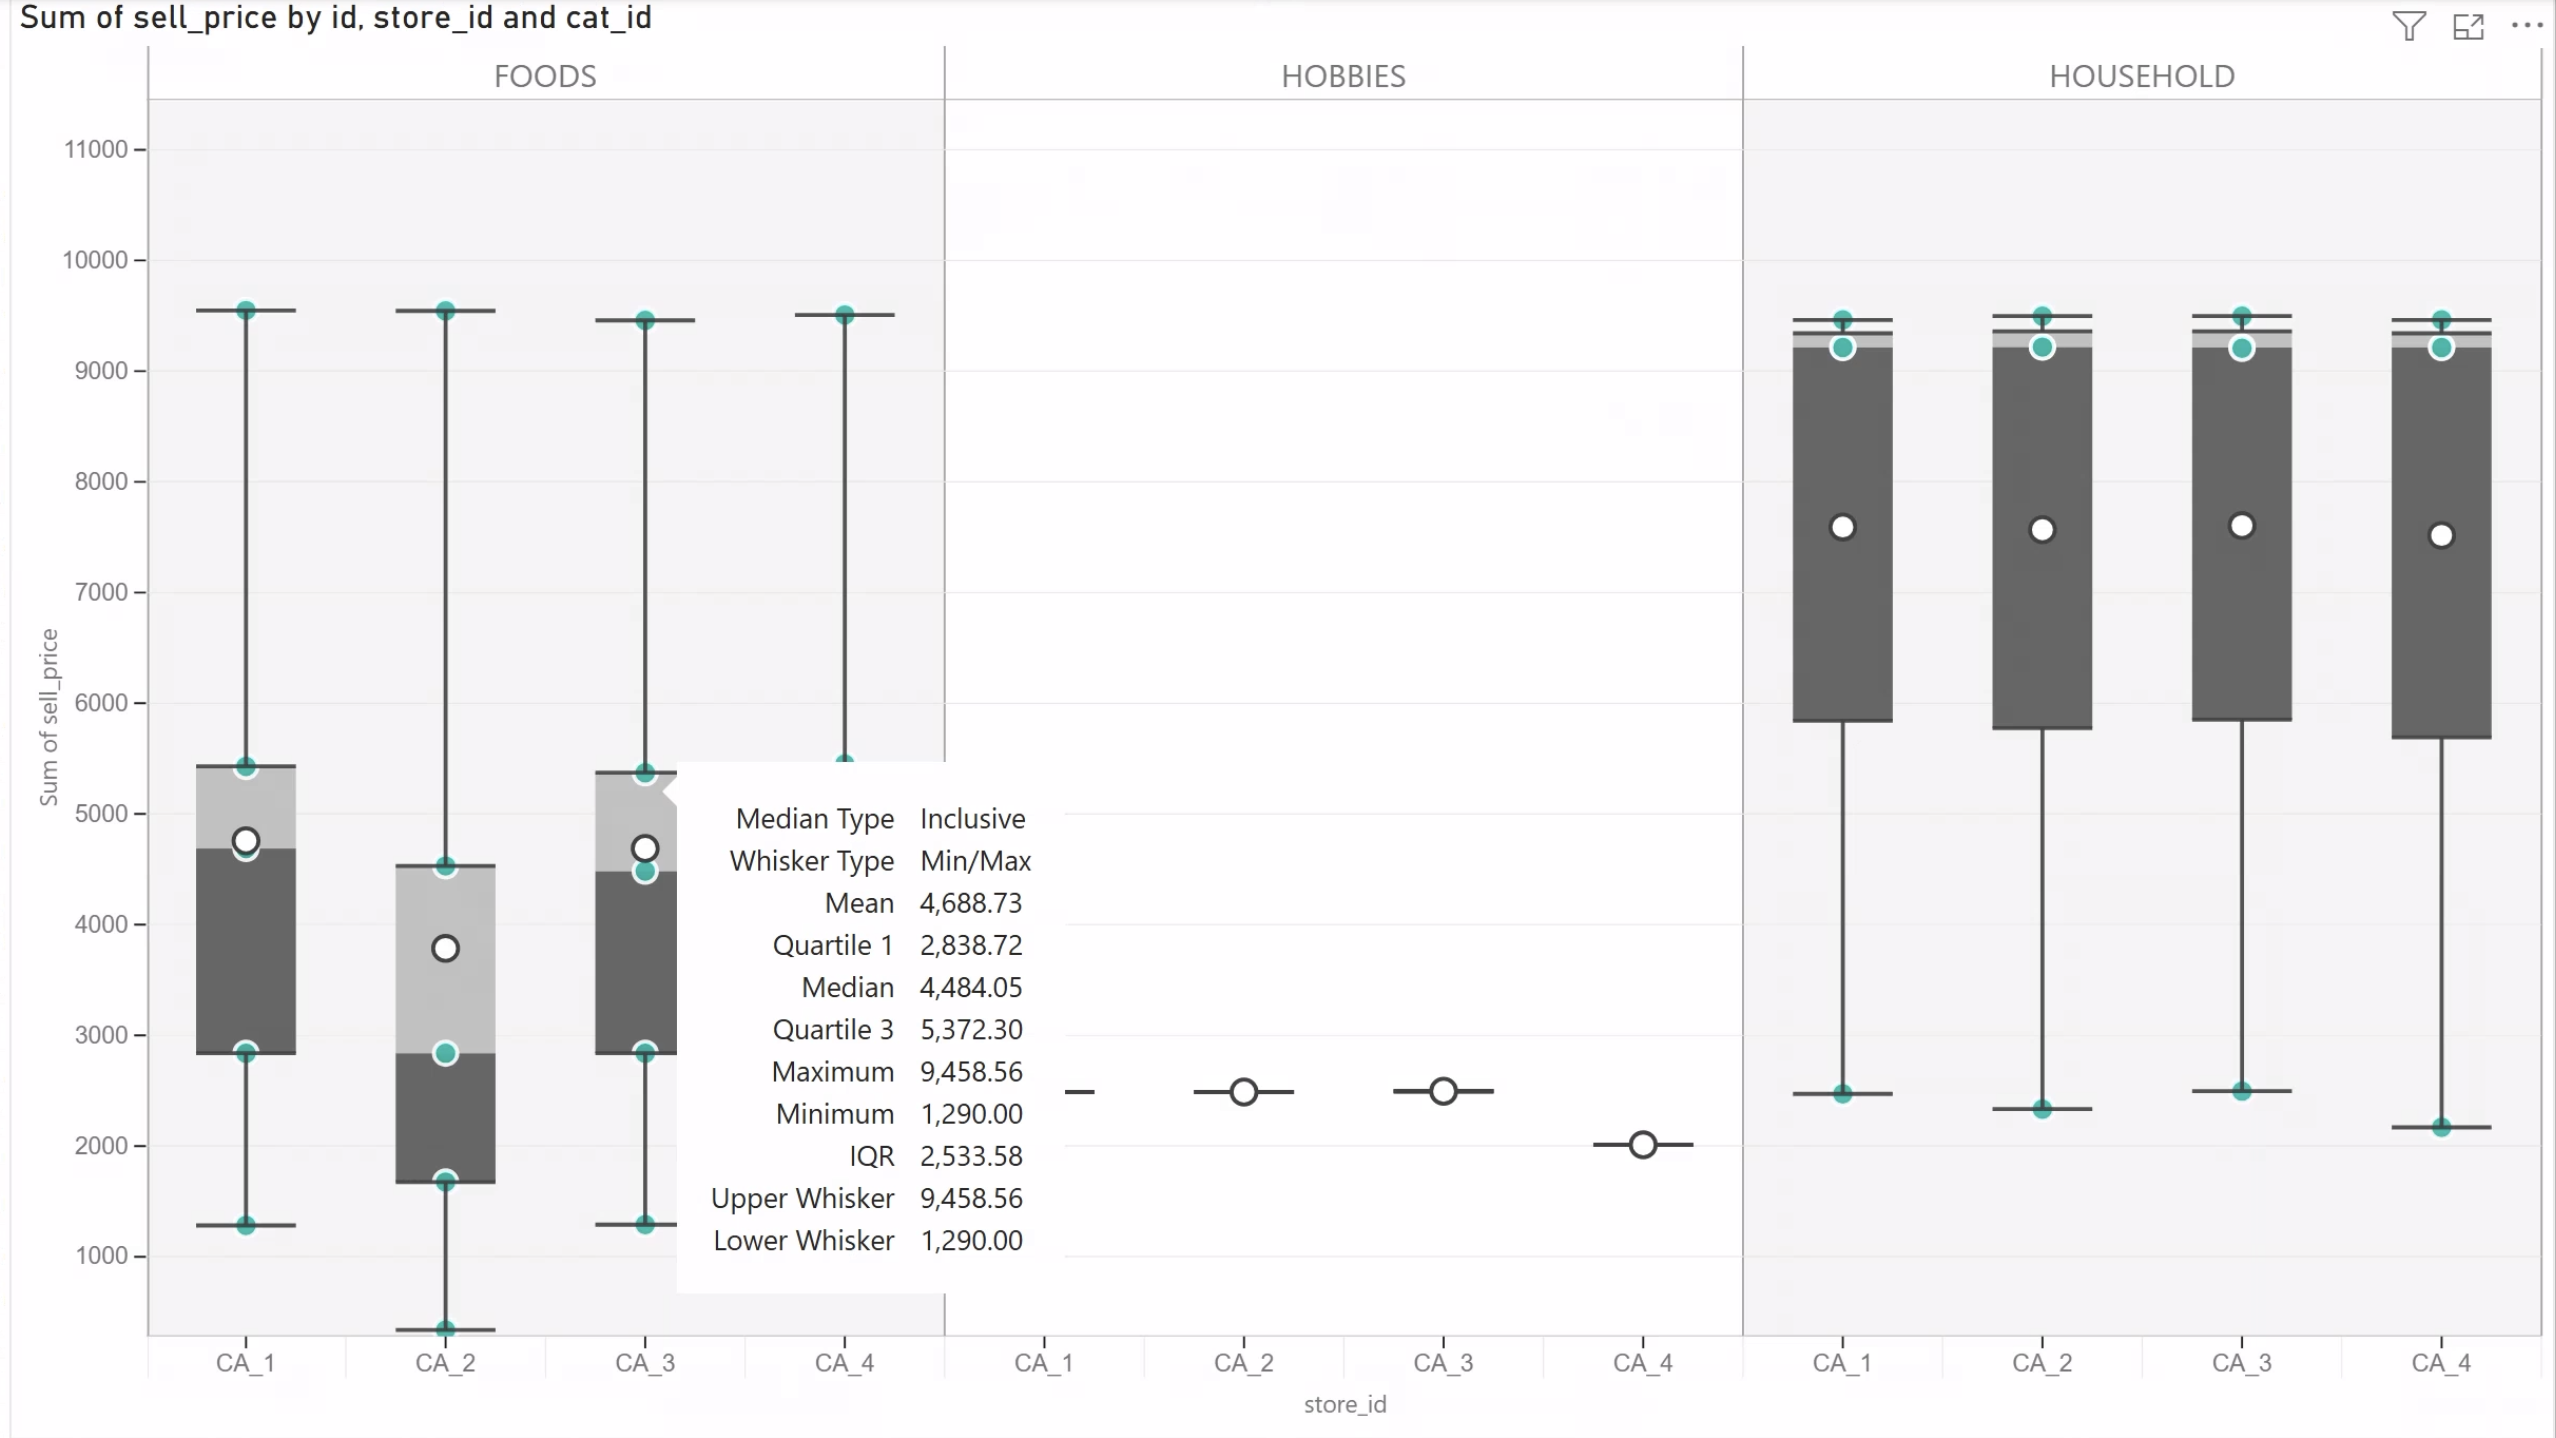